# Set Up

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import yt
import unyt
import tqdm
import pandas as pd
import trident as tr
from trident.absorption_spectrum.absorption_line import tau_profile
from linetools.lists.linelist import LineList

In [2]:
from linetools.analysis import absline
import astropy.units as u

# Parameters

In [51]:
# Location of the target snapshot
simulation_fp = '/Users/zhafen/data/fire/fire2/metal_diffusion/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5'
# simulation_fp = '/Users/zhafen/data/fire/fire2/metal_diffusion/m12z_res4200/output/snapdir_600/snapshot_600.0.hdf5'
# simulation_fp = '/Users/zhafen/data/fire/fire2/metal_diffusion/m12i_res57000/output/snapshot_600.hdf5'

# Location of the halo file if provided. If use_halo_file == False then the center will be found automatically.
use_halo_file = True
halo_catalog_fp = '/Users/zhafen/data/fire/fire2/metal_diffusion/m12i_res7100/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5'
# halo_catalog_fp = '/Users/zhafen/data/fire/fire2/metal_diffusion/m12z_res4200/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5'
# halo_catalog_fp = '/Users/zhafen/data/fire/fire2/metal_diffusion/m12i_res57000/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5'

tag = 'm12i_md'
# tag = 'm12z_md'

image_data_fp = './images.h5'

# Projection choices
proj_halfwidth_kpc = 25. # Halfwidth in units of kpc
proj_xrange_width = np.array([ -0.5, 0.5 ]) # Slice location in units of width
default_resolution = 800 # Points per side

# Location and width of inset in kpc
zoom_yrange_kpc = np.array([ -20, -10 ])
zoom_zrange_kpc = np.array([ 6, 11 ])

# Obs choices
EW_min = 0.01
EW_max = 1.0
b_default = 30. # In km/s
angular_resolution = 1 # In units of arcmin

In [4]:
# Presentation
figure_width = 3.376 # Default figure width in inches; MNRAS column width
max_figure_height = 9.437 # Text height for MNRAS
large_fontsize = 14.4
normal_fontsize = 12
small_fontsize = 10.95

cmap = 'cubehelix'

# Load Data

In [5]:
np.set_printoptions(precision=20)

In [6]:
ds = yt.load( simulation_fp )

yt : [INFO     ] 2022-11-11 21:19:11,175 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2022-11-11 21:19:11,177 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2022-11-11 21:19:11,293 Parameters: current_time              = 4.3545571088051405e+17 s
yt : [INFO     ] 2022-11-11 21:19:11,294 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-11-11 21:19:11,296 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-11-11 21:19:11,297 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2022-11-11 21:19:11,298 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-11-11 21:19:11,298 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2022-11-11 21:19:11,299 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2022-11-11 21:19:11,300 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2022-11-11 21:19:11,300 Parameters: omega_radiation           = 0.

In [7]:
data = ds.all_data()

yt : [INFO     ] 2022-11-11 21:19:11,549 Allocating for 1.471e+08 particles
Loading particle index: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 34583.81it/s]


In [8]:
tr.add_ion_fields( ds, ions=['O VI','C IV', 'Si II', 'Mg II','Na I'],)

/Users/zhafen/miniconda3/envs/general/lib/python3.10/site-packages/unyt/array.py:1758: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


## The Center of Galaxy Using Halo Data

In [9]:
kpc = ds.quan( 1, 'kpc' )

In [10]:
if use_halo_file:
    import h5py
    f = h5py.File( halo_catalog_fp, 'r' ) #f is a dictionary, so you can do f.keys()
    index = f['mass'][...].argmax() 

    #... means indexing all of it, because HDF5 doesn't show you everything unless you ask for it
    #.argmax() gets the index of maximum.
    #maximum mass is center because host galaxy is the one in the center so it should have the most mass.

    center_ckpc = f['position'][...][index]
    #the actual code to bring it to modern day, getting physical distance, is below. 
    #not used because error but f[redshift] is 0 so it's basically center_ckpc

    center_kpc = center_ckpc / ( 1. + f['snapshot:redshift'][...] )

    center = center_kpc * kpc
else:
    print( 'Finding center using maximum density' )
    _, center = ds.find_max( ('gas', 'density') )
    center_kpc = center.to( 'kpc' ).value

## Create coordinate frame

In [11]:
# Get dataset units
kpc = ds.quan( 1, 'kpc' )

# Calculate the angular momentum (extracting a sphere around the galaxy first for it).
# `center` is the center of the galaxy in kpc.
sp = ds.sphere( center , (10, "kpc")) #10 is radius
jtot = sp.quantities.angular_momentum_vector( particle_type='PartType4' ).to( 'kpc * km / s' ).value

# Unit vectors for a frame w/ zhat aligned with the total angular momentum
zhat = jtot / np.linalg.norm( jtot ) #basically getting the unit vector by dividing jtot vector by its magnitude

#cross product of zhat and some vector to get a vector that's perpendicular to zhat (along galaxy disk):
xhat = np.cross( [ 1, 0, 0 ], zhat )
xhat /= np.linalg.norm( xhat )

# Sun position in simulation coordinates -> 8 kpc from center at an arbitrary angle
sun_position = center + (8. * xhat * kpc)

# Unit vectors for on-sky coordinate system.
# xskyhat points from the sun to the center of the galaxy.
# zskyhat points parallel to the axis of total angular momentum.
# yskyhat (should) point to the left on a sky map.
xskyhat = -xhat
zskyhat = zhat
yskyhat = np.cross( zskyhat, xskyhat )

In [12]:
# Not currently used

# gas_coordinates = (data[('PartType0', 'Coordinates')]).in_units("kpc")

# #apply distance formula from each star coordinate to the center. if <150 kpc, it is within a good range.
# distance_to_center=np.sqrt( (gas_coordinates[:,0]-center[0] )**2 + (gas_coordinates[:,1]-center[1])**2 +(gas_coordinates[:,2]-center[2])**2 )

# within_range = distance_to_center < (150.*kpc)
# galaxy_gas = gas_coordinates[within_range]


In [13]:
# # These new positions aren't currently used

# # Given a series of positions (the undefined vector)
# # shift them over, i.e. make a new frame centered on the sun.
# positions_sun = galaxy_gas - sun_position

# # And now rotate them to the sky frame
# positions_sky = np.array([
#     np.dot( positions_sun, xskyhat ), # Check the axis argument, this may not be right
#     np.dot( positions_sun, yskyhat ),
#     np.dot( positions_sun, zskyhat ),
#     ]).transpose()

# Enable angular resolution conversion

In [14]:
def _dsun( field, data ):
    '''Distance to the sun.'''
    return np.linalg.norm(
        data["gas", "Coordinates"] - 
        sun_position,
        axis = 1
    )

In [15]:
yt.add_field(
    name='dsun',
    function=_dsun,
    sampling_type='local',
    units='kpc',
)

# Generate Images

## General Function

In [16]:
yrange_full_proj_kpc = np.array([ -1, 1 ]) * proj_halfwidth_kpc
zrange_full_proj_kpc = np.array([ -1, 1 ]) * proj_halfwidth_kpc

In [17]:
def get_image( field, yrange_kpc=yrange_full_proj_kpc, zrange_kpc=zrange_full_proj_kpc, method='yt', resolution=default_resolution ):
    '''The output from this is *just* an array.
    '''
    
    # Convert ranges to unyt
    yrange = yrange_kpc * kpc
    zrange = zrange_kpc * kpc
    proj_xrange_kpc = proj_xrange_width * proj_halfwidth_kpc * 2.
    proj_xrange = proj_xrange_kpc * kpc
    
    # Get width/depth
    proj_ywidth_kpc = yrange_kpc[1] - yrange_kpc[0]
    proj_zwidth_kpc = zrange_kpc[1] - zrange_kpc[0]
    proj_depth_kpc = proj_xrange_kpc[1] - proj_xrange_kpc[0]
    
    # Image frame for adjustment
    xhat_img = xhat
    yhat_img = - np.cross( zhat, xhat )
    zhat_img = zhat

    # Recenter
    new_center = (
        sp.center
        + xhat_img * 0.5 * ( proj_xrange[0] + proj_xrange[1] )
        + yhat_img * 0.5 * ( yrange[0] + yrange[1] )
        + zhat_img * 0.5 * ( zrange[0] + zrange[1] )
    )
    
    # Locations of projections
    y_centers = np.linspace( yrange_kpc[0], yrange_kpc[1], resolution )
    z_centers = np.linspace( zrange_kpc[0], zrange_kpc[1], resolution )
    dy = y_centers[1] - y_centers[0]
    dz = z_centers[1] - z_centers[0]
    y_edges = np.arange( y_centers[0] - dy/2., y_centers[-1] + 0.5000001*dy, dy, )
    z_edges = np.arange( z_centers[0] - dz/2., z_centers[-1] + 0.5000001*dz, dz, )
    
    supplementary_data = {}
    supplementary_data['new_center'] = new_center
        
    if method == 'yt':
        image = yt.off_axis_projection(
            ds,
            center = new_center.to( 'kpc' ),
            normal_vector = xhat,
            width = ( np.array([ proj_ywidth_kpc, proj_zwidth_kpc, proj_depth_kpc ]) * kpc ).to( 'kpc' ),
            resolution = (default_resolution, default_resolution),
            item = field,
            north_vector = zhat,
        )
        
    # Histogram, good for checking
    elif method == 'histogram':
        
        coords = ( sp[('PartType0', 'Coordinates')] - sp.center ).to( 'kpc' ).value
                
        x_img = np.dot( coords, xhat_img )
        y_img = np.dot( coords, yhat_img )
        z_img = np.dot( coords, zhat_img )
        
        supplementary_data['y_edges'] = y_edges
        supplementary_data['z_edges'] = z_edges
        
        field_density = ds[field]
        volume = ds[('PartType0', 'mass')] / sp[('gas', 'density')]
        field_mass = field_density * volume
        
        try:
            field_mass = field_mass.to( 'Msun' ).value
            is_number_density_field = False
        # Number densities
        except:
            field_mass = ( field_mass * unyt.mp ).to( 'Msun' ).value
            is_number_density_field = True
        
        image, _, _ = np.histogram2d(
            y_img,
            z_img,
            weights = field_mass,
            bins = [ y_edges, z_edges ],
        )
        
        # Divide by bin area
        image /= dy * dz
        
        # Add units again
        image *= unyt.Msun / unyt.kpc**2.
        
        if is_number_density_field:
            image /= unyt.mp
        
    return image, supplementary_data

## Loop to get images

In [18]:
fields = [ ( 'gas', 'density' ), 'Na_p0_number_density' ]
field_units = [ 'Msun/kpc**2', 'cm**-2' ]
# fields = [ 'Na_p0_number_density' ]
# field_units = [ 'cm**-2' ]

In [19]:
# Full projection images
imgs = []
for i, field in enumerate( tqdm.tqdm( fields ) ):
    img, supplementary_data = get_image( field, )
    imgs.append( img.to( field_units[i] ) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [05:06<00:00, 153.29s/it]


In [52]:
# Zoom images
zoom_imgs = []
zoom_supplements = []
for i, field in enumerate( tqdm.tqdm( fields ) ):
    img, supplementary_data = get_image( field, zoom_yrange_kpc, zoom_zrange_kpc )
    zoom_supplements.append( supplementary_data )
    zoom_imgs.append( img.to( field_units[i] ) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:37<00:00, 138.91s/it]


# Convert to Equivalent Width

## Curve of Growth

### Get range

In [53]:
linelist = LineList( 'ISM' )
NaI_lines = linelist.all_transitions( (11,1) )
transition = NaI_lines['name'][0]

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [54]:
colden_min = absline.N_from_Wr_transition( EW_min * u.angstrom, transition ).value

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


### Calculate

In [55]:
coldens_cog = np.logspace( np.log10( colden_min ), 20, 1001 ) * u.cm**-2
bs = np.arange( 0., 50, 5., )

In [56]:
EWs_cog = []
for b in bs:
    EWs_b = absline.Wr_from_N_b_transition( coldens_cog, np.full( coldens_cog.shape, b ) * u.km / u.s, transition ).value
    EWs_cog.append( EWs_b )

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


/Users/zhafen/miniconda3/envs/general/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/zhafen/miniconda3/envs/general/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/zhafen/miniconda3/envs/general/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [57]:
EWs_default = absline.Wr_from_N_b_transition( coldens_cog, np.full( coldens_cog.shape, b_default ) * u.km / u.s, transition ).value

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [58]:
color_norm = matplotlib.colors.Normalize( vmin=bs[0], vmax=bs[-1] )
colormap = matplotlib.colormaps.get( 'viridis' )

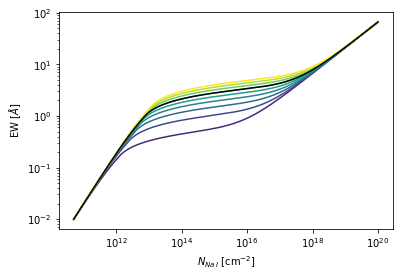

In [59]:
# Plot curve of growth
fig = plt.figure()
ax = plt.gca()

for i, EWs_b in enumerate( EWs_cog ):
    ax.plot(
        coldens_cog,
        EWs_b,
        color = colormap( color_norm( bs[i] ) ),
    )
    
ax.plot(
    coldens_cog,
    EWs_default,
    color = 'k',
)

ax.set_xlabel( r'$N_{Na\,I}$ [cm$^{-2}$]' )
ax.set_ylabel( r'EW [$\AA$]' )

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

### Create interpolation function

In [60]:
EW_interp_fn = scipy.interpolate.interp1d( coldens_cog, EWs_default )

## Conversion Itself

In [61]:
# Full projection
coldens = imgs[-1]
coldens[coldens<colden_min] = colden_min
EWs = EW_interp_fn( coldens )
EWs_masked = np.ma.masked_where( EWs <= EW_min, EWs )

In [62]:
# Zoom
coldens_zoom = zoom_imgs[-1]
coldens_zoom[coldens_zoom<colden_min] = colden_min
EWs_zoom = EW_interp_fn( coldens_zoom )
EWs_zoom_masked = np.ma.masked_where( EWs_zoom <= EW_min, EWs_zoom )

# Plot

## Setup

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [64]:
ys = np.linspace( yrange_full_proj_kpc[0], yrange_full_proj_kpc[1], default_resolution )
zs = np.linspace( zrange_full_proj_kpc[0], zrange_full_proj_kpc[1], default_resolution )

In [65]:
ys_zoom = np.linspace( zoom_yrange_kpc[0], zoom_yrange_kpc[1], default_resolution )
zs_zoom = np.linspace( zoom_zrange_kpc[0], zoom_zrange_kpc[1], default_resolution )

In [66]:
colden_norm = matplotlib.colors.LogNorm( vmin=colden_min, vmax=coldens.max() )
norm = matplotlib.colors.LogNorm( vmin=EW_min, vmax=EW_max )

In [67]:
fontproperties = fm.FontProperties( size=normal_fontsize )

In [68]:
def plot_zoom_region( ax, color='r' ):
    
    # Plot zoom-in area
    xy = [ zoom_yrange_kpc[0], zoom_zrange_kpc[-1] ]
    width = zoom_yrange_kpc[1] - zoom_yrange_kpc[0]
    height = zoom_zrange_kpc[1] - zoom_zrange_kpc[0]
    zoom_region = matplotlib.patches.Rectangle(
        xy,
        width,
        -height,
        fill = False,
        linewidth = 3,
        color = color,
    )
    ax.add_patch( zoom_region )

In [69]:
def basic_plot( ys, zs, img_arr, ax=None, norm=None ):
    
    # Projected
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()

    plotted_img = ax.pcolormesh(
        ys,
        zs,
        np.rot90( img_arr, k=-1  ),
        norm = norm,
    )

    ax.set_aspect( 'equal' )
    
    return plotted_img, ax

In [70]:
def ratio_plot( ys, zs, img_arr1, img_arr2 ):
    '''Good for comparing different methods of creating the images.'''
    
    # Projected ratio
    fig = plt.figure()
    ax = plt.gca()

    ratio_img = ax.pcolormesh(
        ys,
        zs,
        np.rot90( hist_imgs[-1] / coldens, k=-1 ),
        norm = matplotlib.colors.LogNorm( vmin=0.1, vmax=10 ),
        cmap = 'RdBu',
    )

    # Add colorbar
    divider = make_axes_locatable( ax )
    cax = divider.append_axes("right", size="5%", pad='2%')
    plt.colorbar( ratio_img, cax=cax )

    ax.set_aspect( 'equal' )
    
    return fig, ax

## Column Density Images

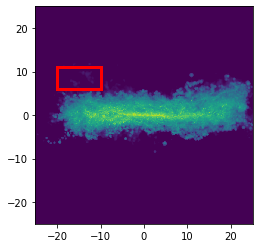

In [71]:
# Overall
plotted_img, ax = basic_plot( ys, zs, coldens, norm=colden_norm )

plot_zoom_region( ax )

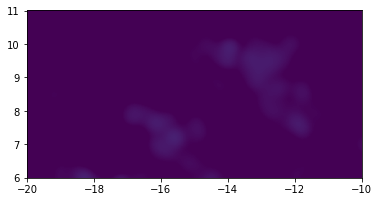

In [72]:
# Zoom
plotted_img, ax = basic_plot( ys_zoom, zs_zoom, coldens_zoom, norm=colden_norm  )

## EW Images

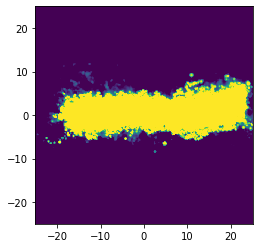

In [73]:
# Overall
plotted_img, ax = basic_plot( ys, zs, EWs, norm=norm  )

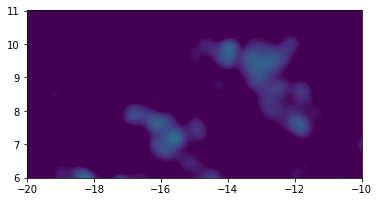

In [74]:
# Zoomed
plotted_img, ax = basic_plot( ys_zoom, zs_zoom, EWs_zoom, norm=norm )

## Publication-Quality Image

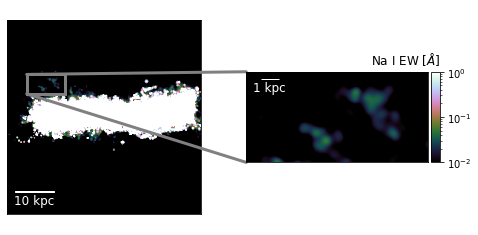

In [75]:
# Projected
fig = plt.figure(figsize=(figure_width*2,figure_width), facecolor='w')
main_ax = plt.gca()
main_ax.set_axis_off()
axs = fig.subplot_mosaic(
    mosaic = [ [ 'full', 'zoom', ] ],
)

# Full image
axs['full'].pcolormesh(
    ys,
    zs,
    np.rot90( EWs, k=-1 ),
    norm = norm,
    cmap = cmap,
)

# Add inset box
rectangle_path, connector_lines = axs['full'].indicate_inset(
    bounds = [ zoom_yrange_kpc[0], zoom_zrange_kpc[0], zoom_yrange_kpc[1] - zoom_yrange_kpc[0], zoom_zrange_kpc[1] - zoom_zrange_kpc[0] ],
    inset_ax = axs['zoom'],
    edgecolor = '0.5',
    linewidth = 3,
    alpha = 1,
)
for line in connector_lines:
    line.set_linewidth( 3 )

# Zoom-in
EWs_zoom_img = axs['zoom'].pcolormesh(
    -ys_zoom,
    zs_zoom,
    np.transpose( EWs_zoom, ),
    norm = norm,
    cmap = cmap,
)

# Add colorbar
divider = make_axes_locatable( axs['zoom'] )
cax = divider.append_axes("right", size="5%", pad='2%')
plt.colorbar( EWs_zoom_img, cax=cax )

# Add annotation
cax.annotate(
    text = 'Na I EW [$\AA$]',
    xy = ( 1, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 0, 5 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'bottom',
    fontsize = normal_fontsize,
)

# Loop through to add a few things
scalebar_sizes = {
    'full': 10,
    'zoom': 1,
}
scalebar_locations = {
    'full': 'lower left',
    'zoom': 'upper left',
}
for ax_key, ax in axs.items():
    
    # Tick marks
    ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
    
    # Aspect ratio
    ax.set_aspect( 'equal' )
    
    # Scalebar
    scalebar = AnchoredSizeBar(
        ax.transData,
        scalebar_sizes[ax_key],
        '{} kpc'.format( scalebar_sizes[ax_key] ),
        loc = scalebar_locations[ax_key],
        pad=0.5,
        color='white',\
        frameon=False,
        size_vertical = scalebar_sizes[ax_key] / 50,
        fontproperties = fontproperties,
    )

    ax.add_artist(scalebar)
    
plt.tight_layout()

In [76]:
zoom_tag = 'ys{}to{}_zs{}to{}'.format( zoom_yrange_kpc[0], zoom_yrange_kpc[1], zoom_zrange_kpc[0], zoom_zrange_kpc[1] )
save_fp = './visuals_pngs/polished_{}_{}.png'.format( tag, zoom_tag )
fig.savefig( save_fp, dpi=300 )

## Save Image Data

In [77]:
assert False, "Doesn't save unless you run this area explicitly."

AssertionError: Doesn't save unless you run this area explicitly.

In [78]:
import verdict

In [79]:
d = verdict.Dict.from_hdf5( image_data_fp, create_nonexistent=True )

In [80]:
# Store zoom
d.setitem( tag, EWs_zoom, zoom_tag, 'zoom', 'img_arr' )
d.setitem( tag, proj_xrange_width * proj_halfwidth_kpc, zoom_tag, 'zoom', 'proj_xrange_width' )
d.setitem( tag, ys_zoom, zoom_tag, 'zoom', 'ys' )
d.setitem( tag, zs_zoom, zoom_tag, 'zoom', 'zs' )

In [81]:
# Store zoom
d.setitem( tag, EWs, zoom_tag, 'full', 'img_arr' )
d.setitem( tag, proj_xrange_width * proj_halfwidth_kpc, zoom_tag, 'full', 'proj_xrange_width' )
d.setitem( tag, ys, zoom_tag, 'full', 'ys' )
d.setitem( tag, zs, zoom_tag, 'full', 'zs' )

In [82]:
d.to_hdf5( image_data_fp, )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.81s/it]


# TPCF

In [ ]:
assert False, 'Not fully implemented yet..'

## Calculate weighted TPCF

In [ ]:
import stained_glass.stats

In [ ]:
y_mesh, z_mesh = np.meshgrid( ys, zs )
coords = np.array([ y_mesh.flatten(), z_mesh.flatten(), ]).transpose()
weights = EWs.flatten()

In [ ]:
# Toss out non-detections
is_detectable = weights > EW_min
coords = coords[is_detectable]
weights = weights[is_detectable]

In [ ]:
edges = np.logspace( -2, np.log10( zoom_width ) )
tpcf, edges, info = stained_glass.stats.weighted_tpcf(
    coords,
    weights = weights,
    edges = edges,
    return_info = True,
)

In [ ]:
centers = 0.5 * ( edges[:-1] + edges[1:] )

In [ ]:
# Characteristic cloud size
interp_fn = scipy.interpolate.interp1d( tpcf, centers )
l_cloud = interp_fn( 0.5 )

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.plot(
    centers,
    tpcf,
    color = 'k',
    linewidth = 1.5,
)

# Characteristic cloud size
ax.axvline(
    l_cloud,
    color = 'k',
    linewidth = 1,
    linestyle = '--',
)
ax.axhline(
    0,
    color = '0.9',
    zorder = -10,
)

ax.set_xscale( 'log' )
ax.set_ylim( -1, 1 )
ax.set_xlim( centers[0], centers[-1] )